In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Model Hyperparamters
GAMMA = 0.995
LR = 3e-5 # Suitable for our Model
MAX_EPISODES = 20000
UPDATE_INTERVAL = 30
ENV_NAME = "BipedalWalker-v3"
NUM_WORKERS = 4
ENTROPY_BETA = 0.005
GRAD_CLIP = 2
REWARD_SCALE = 0.5

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim=24, output_dim=4):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)   # 24- 256
        self.fc2 = nn.Linear(256, 128)          #256-128
        self.actor_mu = nn.Linear(128, output_dim)      # 128-4
        self.actor_log_std = nn.Parameter(torch.zeros(output_dim))
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = torch.tanh(self.actor_mu(x))  # Mean of action distribution, bounded to [-1, 1] to match action space
        std = self.actor_log_std.exp().expand_as(mu)
        dist = torch.distributions.Normal(mu, std)
        value = self.critic(x)   # Predict the state value
        return dist, value


In [ ]:
class Worker(mp.Process):
    def __init__(self, gnet, optimizer, global_ep, res_queue, name):
        super(Worker, self).__init__()
        self.name = f"worker_{name}"
        self.env = gym.make(ENV_NAME)
        self.g_ep = global_ep
        self.res_queue = res_queue
        self.gnet = gnet
        self.optimizer = optimizer
        self.lnet = ActorCritic(24, 4)

    def run(self):
        total_step = 1
        while self.g_ep.value < MAX_EPISODES:
            obs, _ = self.env.reset()
            state = obs
            buffer_s, buffer_a, buffer_r = [], [], []
            ep_r = 0

            while True:
                s_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                dist, _ = self.lnet(s_tensor)
                action = dist.sample()[0]
                action_clipped = action.clamp(-1, 1).detach().numpy()

                obs, reward, terminated, truncated, _ = self.env.step(action_clipped)
                done = terminated or truncated
                next_state = obs

                buffer_s.append(state)
                buffer_a.append(action)
                buffer_r.append(reward * REWARD_SCALE)

                ep_r += reward
                state = next_state

                if total_step % UPDATE_INTERVAL == 0 or done:
                    self.update_global(done, next_state, buffer_s, buffer_a, buffer_r)
                    buffer_s, buffer_a, buffer_r = [], [], []

                if done:
                    with self.g_ep.get_lock():
                        self.g_ep.value += 1
                    self.res_queue.put((self.name, ep_r))
                    break
                total_step += 1

    def update_global(self, done, next_state, bs, ba, br):
        if done:
            R = 0
        else:
            s_ = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            _, v = self.lnet(s_)
            R = v.item()

        buffer_v_target = []
        for r in reversed(br):
            R = r + GAMMA * R
            buffer_v_target.append(R)
        buffer_v_target.reverse()

        loss = self.compute_loss(bs, ba, buffer_v_target)

        self.optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(self.lnet.parameters(), GRAD_CLIP)

        for lp, gp in zip(self.lnet.parameters(), self.gnet.parameters()):
            if gp.grad is None:
                gp._grad = lp.grad
            else:
                gp._grad += lp.grad
        self.optimizer.step()
        self.lnet.load_state_dict(self.gnet.state_dict())

    def compute_loss(self, states, actions, targets):
        s = torch.tensor(states, dtype=torch.float32)
        a = torch.stack(actions)
        t = torch.tensor(targets, dtype=torch.float32)

        dist, values = self.lnet(s)
        log_probs = dist.log_prob(a)
        entropy = dist.entropy().mean()

        advantage = t - values.squeeze()
        actor_loss = -(log_probs.sum(dim=1) * advantage.detach()).mean()
        critic_loss = F.mse_loss(values.squeeze(), t)
        return actor_loss + 0.5 * critic_loss - ENTROPY_BETA * entropy

In [ ]:
rewards = []
def train():
    gnet = ActorCritic(24, 4)
    gnet.share_memory()
    optimizer = torch.optim.Adam(gnet.parameters(), lr=LR)
    global_ep = mp.Value('i', 0)
    res_queue = mp.Queue()

    workers = [Worker(gnet, optimizer, global_ep, res_queue, i) for i in range(NUM_WORKERS)]
    [w.start() for w in workers]

    
    episode = 0
    while True:
        msg = res_queue.get()
        if msg is not None:
            worker_name, r = msg
            rewards.append(r)
            if (episode + 1) % 10 == 0:
                print(f"[{worker_name}] Episode {episode + 1}/{MAX_EPISODES} | Reward: {r:.2f}")
            episode += 1
        if global_ep.value >= MAX_EPISODES:
            break

    [w.join() for w in workers]

    plt.figure(figsize=(10, 4))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("A3C on BipedalWalker-v3")
    plt.grid(True)
    plt.show()

    return gnet

[worker_2] Episode 10/20000 | Reward: -107.56
[worker_2] Episode 20/20000 | Reward: -108.96
[worker_1] Episode 30/20000 | Reward: -118.36
[worker_0] Episode 40/20000 | Reward: -109.13
[worker_0] Episode 50/20000 | Reward: -104.84
[worker_2] Episode 60/20000 | Reward: -103.67
[worker_2] Episode 70/20000 | Reward: -105.36
[worker_2] Episode 80/20000 | Reward: -108.71
[worker_0] Episode 90/20000 | Reward: -109.66
[worker_1] Episode 100/20000 | Reward: -112.32
[worker_0] Episode 110/20000 | Reward: -104.99
[worker_1] Episode 120/20000 | Reward: -120.91
[worker_2] Episode 130/20000 | Reward: -120.30
[worker_1] Episode 140/20000 | Reward: -120.20
[worker_2] Episode 150/20000 | Reward: -103.26
[worker_2] Episode 160/20000 | Reward: -111.05
[worker_0] Episode 170/20000 | Reward: -117.38
[worker_3] Episode 180/20000 | Reward: -106.38
[worker_2] Episode 190/20000 | Reward: -117.92
[worker_2] Episode 200/20000 | Reward: -114.87
[worker_2] Episode 210/20000 | Reward: -111.19
[worker_3] Episode 220

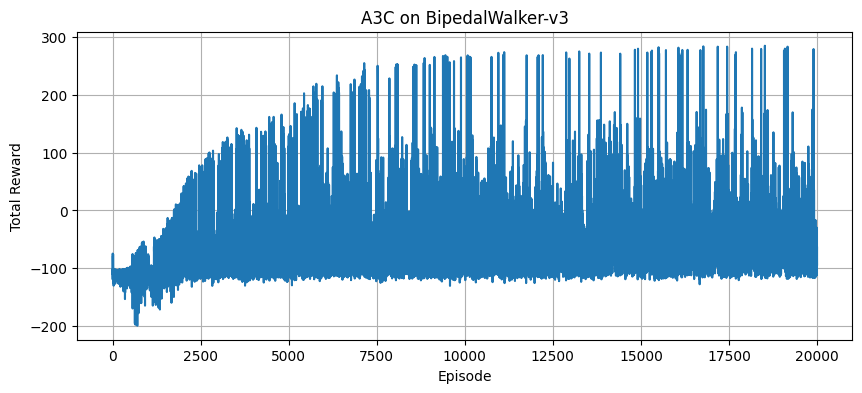

In [ ]:
gnet=train()

In [ ]:
def evaluate(gnet, num_episodes=10):
    gnet.eval()
    env = gym.make(ENV_NAME)
    eval_rewards = []
    for ep in range(num_episodes):
        obs, _ = env.reset()
        state = obs
        done = False
        total_reward = 0

        while not done:
            s_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                dist, _ = gnet(s_tensor)
                action = dist.mean[0]
            action_clipped = action.clamp(-1, 1).numpy()
            obs, reward, terminated, truncated, _ = env.step(action_clipped)
            state = obs
            done = terminated or truncated
            total_reward += reward

        eval_rewards.append(total_reward)
        print(f"[Eval] Episode {ep+1}/{num_episodes} | Reward: {total_reward:.2f}")

    plt.figure(figsize=(10, 4))
    plt.plot(eval_rewards, marker='o')
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Total Reward")
    plt.title("Greedy Evaluation on BipedalWalker-v3")
    plt.grid(True)
    plt.show()

    return eval_rewards


[Eval] Episode 1/10 | Reward: 298.51
[Eval] Episode 2/10 | Reward: 300.91
[Eval] Episode 3/10 | Reward: -94.13
[Eval] Episode 4/10 | Reward: 298.64
[Eval] Episode 5/10 | Reward: 299.11
[Eval] Episode 6/10 | Reward: -37.35
[Eval] Episode 7/10 | Reward: 299.98
[Eval] Episode 8/10 | Reward: 299.85
[Eval] Episode 9/10 | Reward: 106.60
[Eval] Episode 10/10 | Reward: -100.40


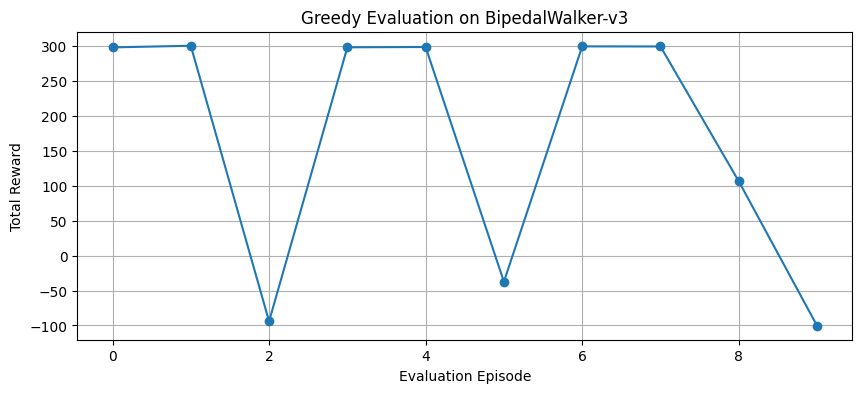

In [ ]:
eval_rewards = evaluate(gnet,10)


In [ ]:
|!apt-get update && apt-get install -y swig


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [73.0 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,692 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,832 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelea

In [ ]:
!pip install box2d-py==2.3.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2351236 sha256=10245dcb0a9805fadeb14de231583a4aa3d42f23202b3fe6538235de523b19c9
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
!python -c "import Box2D; print('Box2D imported successfully')"


Box2D imported successfully
